In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pytz
import os
import sys
import glob

scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(scripts_dir)
from data_generator import normalize_new_data

from datetime import datetime

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
raw_data_1 = pd.read_csv('../data/final_data/cleaned_compiled_data_normalized_part1.csv')
raw_data_2 = pd.read_csv('../data/final_data/cleaned_compiled_data_normalized_part2.csv')

In [4]:
raw_compiled_data = pd.concat([raw_data_1, raw_data_2])
raw_compiled_data['Timestamp'] = pd.to_datetime(raw_compiled_data['Timestamp'])

In [5]:
print(len(raw_compiled_data))
raw_compiled_data.head(5)

300282


,Timestamp,rainfall_S104,rainfall_S107,rainfall_S109,rainfall_S115,rainfall_S116,rainfall_S43,rainfall_S50,air_temperature_S104,air_temperature_S107,...,relative_humidity_S43,relative_humidity_S50,wind_direction_S104,wind_direction_S107,wind_direction_S109,wind_direction_S115,wind_direction_S116,wind_direction_S43,wind_direction_S50,Lightning_Risk
0,2021-03-01 12:20:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.760466,0.579598,...,0.295996,0.268063,0.267515,0.476237,0.510301,0.994161,0.767088,0.308678,0.930719,False
1,2021-03-01 12:25:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777221,0.579598,...,0.271993,0.260265,0.349461,0.493538,0.518495,0.995624,0.755741,0.321385,0.959921,False
2,2021-03-01 12:30:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.793755,0.566595,...,0.281240,0.264154,0.420494,0.490694,0.496368,0.056880,0.728611,0.236810,0.220155,False
3,2021-03-01 12:35:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.804658,0.573113,...,0.270681,0.207943,0.403786,0.499183,0.461368,0.994161,0.726636,0.208459,0.236810,False
4,2021-03-01 12:40:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799219,0.573113,...,0.251269,0.199609,0.407176,0.499183,0.572812,0.983862,0.738409,0.231367,0.964454,False


In [6]:
data = raw_compiled_data.copy()

data = data.set_index('Timestamp')
full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='5min')

data = data.reindex(full_index)

I tried a sequence to multi label classification model which takes a contiguous sequence of weather data to predict lightning presence at 5 points in time in the future.

In [7]:
class SeqToClassLightningDataset(Dataset):
    def __init__(self, compiled_df, timezone_str="Asia/Singapore", hours_lookback=6):
        self.compiled_df = compiled_df.copy()
        self.timezone = pytz.timezone(timezone_str)
        self.samples = []
        self.hours_lookback = hours_lookback

        self._prepare_dataset()

    def _prepare_dataset(self):
        # Ensure datetime index
        self.compiled_df["Timestamp"] = pd.to_datetime(self.compiled_df["Timestamp"])
        if not isinstance(self.compiled_df.index, pd.DatetimeIndex):
            self.compiled_df.set_index("Timestamp", inplace=True)
        self.compiled_df.index = self.compiled_df.index.tz_localize(None)

        ## reindex with the min and max
        full_index = pd.date_range(start=self.compiled_df.index.min(), end=self.compiled_df.index.max(), freq='5min')
        self.compiled_df = self.compiled_df.reindex(full_index)

        nan_mask = self.compiled_df.isna() # find values that are NaN
        gap_id = nan_mask.ne(nan_mask.shift()).cumsum() # find the indices that mark the gaps beween a value and a NaN

        for col in self.compiled_df.columns:
            col_nan_mask = nan_mask[col] 
            col_gap_ids = gap_id[col]
            gap_sizes = col_nan_mask.groupby(col_gap_ids).transform('sum') # find the sizes of the gaps

            to_interpolate = (col_nan_mask) & (gap_sizes <= 24)
            self.compiled_df.loc[~to_interpolate & col_nan_mask, col] = -999999 ## set the NaNs in the large gaps to -999999 to avoid interpolation
            self.compiled_df[col] = self.compiled_df[col].interpolate(limit_direction='both')
            self.compiled_df.loc[self.compiled_df[col] == -999999, col] = np.nan
        
        # Prepare input features and drop target
        input_df = self.compiled_df.drop(columns=["Lightning_Risk"])
        input_columns = input_df.columns.values.tolist()

        # Get valid timestamps
        min_ts = self.compiled_df.index.min().ceil(f"{self.hours_lookback}h") + pd.Timedelta(hours=self.hours_lookback)
        max_ts = self.compiled_df.index.max().floor("2h")
        valid_ts = self.compiled_df.loc[
            (self.compiled_df.index >= min_ts) &
            (self.compiled_df.index <= max_ts) &
            (self.compiled_df.index.hour % 2 == 0) &
            (self.compiled_df.index.minute == 0)
        ].index

        for timestamp in valid_ts:
            try:
                # lookback of 6 hours
                input_data = input_df.loc[timestamp - pd.Timedelta(hours=self.hours_lookback):timestamp - pd.Timedelta(minutes=5)]

                # Output time windows (future)
                output_times = [timestamp + pd.Timedelta(minutes=delta) for delta in [0, 30, 60, 90, 120]]
                output_data = self.compiled_df.loc[output_times, "Lightning_Risk"]

                if input_data.isna().any().any() or output_data.isna().any().any():
                    continue

                input_data = input_data.values.flatten()
                input_data = input_data.reshape(-1, len(input_df.columns))
                # print(input_data.shape)
                output_data = output_data.astype(int).values.flatten()
                
                self.samples.append((input_data, output_data))
            except KeyError:
                continue  # Skip if any timestamps are missing

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [8]:
dataset = SeqToClassLightningDataset(raw_compiled_data, hours_lookback=2)
total_len = len(dataset)

train_end = int(0.8 * total_len)
# val_end = int(0.85 * total_len)

train_set = torch.utils.data.Subset(dataset, list(range(0, train_end)))
val_set = torch.utils.data.Subset(dataset, list(range(train_end, total_len)))
# test_set = torch.utils.data.Subset(dataset, list(range(val_end, total_len)))

C:\Users\ivanc\AppData\Local\Temp\ipykernel_29356\3057445738.py:31: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.compiled_df[col] = self.compiled_df[col].interpolate(limit_direction='both')


In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [10]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_out):
        # lstm_out: [B, T, H]
        weights = self.attn(lstm_out)  # [B, T, 1]
        weights = torch.softmax(weights, dim=1)  # attention over time
        context = torch.sum(weights * lstm_out, dim=1)  # [B, H]
        return context


In [11]:
class LightningLSTMAttn(nn.Module):
    def __init__(self, hours_lookback=6, input_dim=35, hidden_dim=128, dropout=0.2):
        super().__init__()
        self.hours_lookback = hours_lookback
        self.input_dim = input_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.attn = Attention(hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 5)  # 5 future time points
        )

    def forward(self, x):
        x = x.view(x.size(0), self.hours_lookback*12, self.input_dim)  # [B, T, F]
        lstm_out, _ = self.lstm(x)     # [B, T, H]
        context = self.attn(lstm_out)  # [B, H]
        logits = self.fc(context)      # [B, 5]
        return logits  # raw logits → use sigmoid during evaluation


In [12]:
class LightningRiskPredictor(nn.Module):
    def __init__(self, hours_lookback=6, input_dim=35, hidden_dim=128, num_layers=1, dropout=0.2):
        super(LightningRiskPredictor, self).__init__()
        self.hours_lookback=hours_lookback
        self.input_dim = input_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 5)  # 5 future time points
        )

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim] (32, 72, 40)
        x = x.view(x.size(0), self.hours_lookback*12, self.input_dim)  # [B, T, F]
        _, (hn, _) = self.lstm(x)  # Take the last hidden state
        hn = hn[-1]  # [batch_size, hidden_dim] from last LSTM layer
        out = self.fc(hn)  # [batch_size, 5]
        # return torch.sigmoid(out)  # Use Sigmoid if you want probabilities
        return out ## focal loss expects raw logits

In [13]:
x, y = next(iter(train_loader))

In [14]:
x.shape

torch.Size([32, 24, 35])

In [15]:
y.shape

torch.Size([32, 5])

In [16]:
# use a new focal loss criterion
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')  # no sigmoid in model

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()


In [23]:
from sklearn.metrics import f1_score, accuracy_score

def train(dataloader, model, num_epochs, learning_rate, val_dataloader, device='cuda', model_name='lstmWattention'):
    model.to(device)

    # criterion = nn.BCELoss()
    criterion = FocalLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

    avg_loss_history = []
    val_f1_history = []
    val_accuracy_history = []

    best_val_f1 = 0
    epochs_no_improve = 0
    early_stop_patience = 30
    best_model_state = None

    os.makedirs("models", exist_ok=True)
    timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M')

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(dataloader)

        # --- Validation ---
        model.eval()
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for val_inputs, val_targets in val_dataloader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_outputs = torch.sigmoid(val_outputs) ## for focal loss since modified model returns raw logits
                predicted = (val_outputs > 0.5).float()

                all_preds.append(predicted.cpu())
                all_targets.append(val_targets.cpu())

        # Stack all batches
        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        val_f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
        val_acc = accuracy_score(all_targets, all_preds)
        per_class_f1 = f1_score(all_targets, all_preds, average=None, zero_division=0)
        val_f1_history.append(val_f1)
        val_accuracy_history.append(val_acc)
        scheduler.step(val_acc)

        if epoch % 5 == 0:
            avg_loss_history.append(avg_loss)
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Val Accuracy: {val_acc:.4f} | Val F1: {val_f1:.4f}")
            print("per class f1", per_class_f1)

        # --- Early Stopping ---
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print(f"⏹️ Early stopping triggered at epoch {epoch+1} — no F1 improvement in {early_stop_patience} epochs.")
                break

        # Save checkpoint every 20 epochs
        if epoch % 20 == 0:
            torch.save(model.state_dict(), f'models/{model_name}_model_{timestamp}_{avg_loss:.6f}_{epoch}.pth')

    # Save best model
    final_model_path = f'models/{model_name}_{timestamp}_{best_val_f1:.4f}_best.pth'
    if best_model_state:
        torch.save(best_model_state, final_model_path)
        print(f"✅ Best model saved as {final_model_path}")

    # --- Plot ---
    os.makedirs("plots", exist_ok=True)
    plot_filename = f'{model_name}loss_plot_{timestamp}.png'
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    axs[0].plot(range(0, len(avg_loss_history) * 5, 5), avg_loss_history, label='Avg Loss (every 5 epochs)')
    axs[0].set_title('Training Loss')
    axs[0].grid(True)

    axs[1].plot(range(0, len(val_f1_history) * 5, 5), val_f1_history, label='Val F1 Score')
    axs[1].plot(range(0, len(val_accuracy_history) * 5, 5), val_accuracy_history, label='Val Accuracy Score')
    axs[1].set_title('Validation Accuracy and F1 Score')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Score')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join("plots", plot_filename))
    print(f"📈 Plot saved as {plot_filename}")
    plt.show()

    return avg_loss_history, val_f1_history

c:\Users\ivanc\OneDrive - Singapore University of Technology and Design\School Work\Term_8\DL\DL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
c:\Users\ivanc\OneDrive - Singapore University of Technology and Design\School Work\Term_8\DL\DL\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/300 | Loss: 0.0621 | Val Accuracy: 0.8659 | Val F1: 0.1971
per class f1 [0.56680162 0.41880342 0.         0.         0.        ]
Epoch 6/300 | Loss: 0.0479 | Val Accuracy: 0.8684 | Val F1: 0.2751
per class f1 [0.69064748 0.5        0.1849711  0.         0.        ]
Epoch 11/300 | Loss: 0.0455 | Val Accuracy: 0.8667 | Val F1: 0.2849
per class f1 [0.65917603 0.52509653 0.24043716 0.         0.        ]
Epoch 16/300 | Loss: 0.0431 | Val Accuracy: 0.8684 | Val F1: 0.3120
per class f1 [0.66666667 0.52       0.31088083 0.0625     0.        ]
Epoch 21/300 | Loss: 0.0412 | Val Accuracy: 0.8654 | Val F1: 0.3374
per class f1 [0.65957447 0.54826255 0.33333333 0.13333333 0.01265823]
Epoch 26/300 | Loss: 0.0394 | Val Accuracy: 0.8646 | Val F1: 0.3284
per class f1 [0.64882943 0.56370656 0.29850746 0.1183432  0.0125    ]
Epoch 31/300 | Loss: 0.0383 | Val Accuracy: 0.8646 | Val F1: 0.3475
per class f1 [0.62283737 0.54826255 0.38647343 0.15555556 0.02424242]
Epoch 36/300 | Loss: 0.0373 | Val Ac

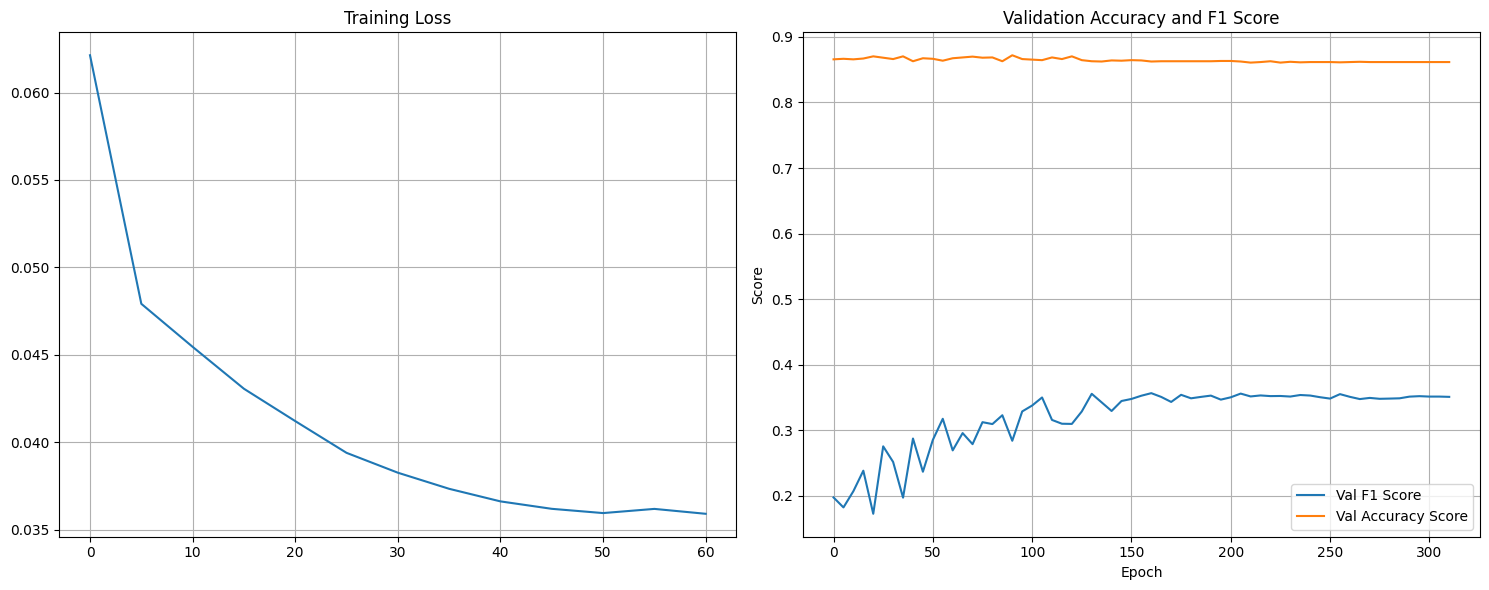

In [31]:
lightning_model = LightningRiskPredictor(hours_lookback=2, input_dim=35)
# lightning_model = LightningLSTMAttn(hours_lookback=2, input_dim=35)

train_losses, val_accuracies = train(
    dataloader=train_loader,
    model=lightning_model,
    num_epochs=300,
    learning_rate=1e-3,
    val_dataloader=val_loader,
    device='cuda',
    model_name="SeqToLabels"
)



Testing

In [32]:
# Define the directory and base filename pattern
file_path_test = "../data/test_data/cleaned_compiled_data_normalized.csv"

# Load and concatenate all parts
test_data = pd.read_csv(file_path_test)

In [33]:
test_data

,Timestamp,rainfall_S104,rainfall_S107,rainfall_S109,rainfall_S115,rainfall_S116,rainfall_S43,rainfall_S50,air_temperature_S104,air_temperature_S107,...,relative_humidity_S43,relative_humidity_S50,wind_direction_S104,wind_direction_S107,wind_direction_S109,wind_direction_S115,wind_direction_S116,wind_direction_S43,wind_direction_S50,Lightning_Risk
0,2025-03-01 00:00:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457706,0.513262,...,0.610020,0.691517,0.341646,0.961434,0.396926,0.389959,0.225818,0.599434,0.299950,False
1,2025-03-01 00:05:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457706,0.520047,...,0.615438,0.693420,0.345573,0.965960,0.393457,0.417200,0.202409,0.604157,0.286433,False
2,2025-03-01 00:10:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457706,0.513262,...,0.617248,0.699143,0.345573,0.967464,0.400369,0.427012,0.169696,0.594676,0.272349,False
3,2025-03-01 00:15:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457706,0.513262,...,0.620876,0.697233,0.337679,0.964454,0.410542,0.396926,0.196212,0.594676,0.267515,False
4,2025-03-01 00:20:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457706,0.513262,...,0.622693,0.697233,0.333670,0.968966,0.410542,0.403786,0.183327,0.611176,0.262607,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6437,2025-04-15 13:35:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.760466,0.667170,...,0.277264,0.471423,0.208459,0.479160,0.433442,0.842434,0.624995,0.403786,0.681828,False
6438,2025-04-15 13:45:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.754831,0.655016,...,0.252547,0.450558,0.410542,0.470341,0.423764,0.837267,0.613500,0.317199,0.601800,False
6439,2025-04-15 13:50:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.754831,0.648896,...,0.249993,0.489376,0.452233,0.473297,0.439786,0.838993,0.601800,0.430238,0.582624,False
6440,2025-04-15 13:55:00+08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.749171,0.648896,...,0.265455,0.477920,0.484958,0.467367,0.427012,0.835538,0.589883,0.547570,0.702531,False


In [34]:
test_dataset = SeqToClassLightningDataset(test_data, hours_lookback=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\ivanc\AppData\Local\Temp\ipykernel_29356\3057445738.py:31: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  self.compiled_df[col] = self.compiled_df[col].interpolate(limit_direction='both')


In [36]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for test_inputs, test_targets in test_loader:
            test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
            test_outputs = model(test_inputs)
            test_outputs = torch.sigmoid(test_outputs) ## for focal loss since modified model returns raw logits
            predicted = (test_outputs > 0.5).float()

            all_preds.append(predicted.cpu())
            all_targets.append(test_targets.cpu())

        # Stack all batches
        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        test_f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
        test_acc = accuracy_score(all_targets, all_preds)
        per_class_f1 = f1_score(all_targets, all_preds, average=None, zero_division=0)

    print(f"macro f1: {test_f1:.2f}, test accuracy: {test_acc:.2f}, per class macro {per_class_f1}")

In [37]:
# test_model = LightningLSTMAttn(input_dim=35, hours_lookback=2)
test_model = LightningRiskPredictor(input_dim=35, hours_lookback=2)
test_model.load_state_dict(torch.load(f"models/SeqToLabels_2025_04_19_22_33_0.3563_best.pth", weights_only=True))
test_model.to(device)
evaluate_model(test_model, test_loader)

macro f1: 0.37, test accuracy: 0.85, per class macro [0.59459459 0.70588235 0.37037037 0.19047619 0.        ]


c:\Users\ivanc\OneDrive - Singapore University of Technology and Design\School Work\Term_8\DL\DL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
